In [76]:
import cv2
from time import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [103]:
def extract_keypoints_and_descriptors(image, method_name):
    if method_name == "orb":
        orb = cv2.ORB_create()
        start_time = time()
        keypoints = orb.detect(image, None)
        end_time = time()
        keypoints, descriptors = orb.compute(image, keypoints)
    elif method_name == "sift":
        sift = cv2.SIFT_create()
        start_time = time()
        keypoints = sift.detect(image, None)
        end_time = time()
        keypoints, descriptors = sift.compute(image, keypoints)
    elif method_name == "shi-thomasi":
        start_time = time()
        corners = cv2.goodFeaturesToTrack(image, maxCorners=1000, qualityLevel=0.001, minDistance=2)
        end_time = time()
        keypoints = [cv2.KeyPoint(x=c[0][0], y=c[0][1], size=20) for c in corners]
        sift = cv2.SIFT_create()
        _, descriptors = sift.compute(image, keypoints)
    return keypoints, descriptors, end_time - start_time

In [125]:
def compute_distance_matrix(points1, points2):
    x_diff = np.subtract.outer(points1[:, 0], points2[:, 0])
    y_diff = np.subtract.outer(points1[:, 1], points2[:, 1])
    distances = np.sqrt(np.square(x_diff) + np.square(y_diff))
    return distances

In [126]:
def calculate_repeatability_motion(image_list, detection_method):
    keypoints_first, _, time_for_first_image = extract_keypoints_and_descriptors(image_list[0], detection_method)
    keypoints_first = cv2.KeyPoint_convert(keypoints_first)
    result = np.zeros((keypoints_first.shape[0], len(image_list) - 1))
    total_time = time_for_first_image
    num_keypoints = len(keypoints_first)
    for i, image in enumerate(tqdm(image_list[1:])):
        (x, y), *_ = cv2.phaseCorrelate(np.float32(image_list[0]), np.float32(image))
        keypoints, _, time_for_image = extract_keypoints_and_descriptors(image, detection_method)
        total_time += time_for_image
        num_keypoints += len(keypoints)
        keypoints = cv2.KeyPoint_convert(keypoints)
        keypoints[:, 0] -= x
        keypoints[:, 1] -= y

        distances = compute_distance_matrix(keypoints_first, keypoints).min(axis=1)
        result[distances < 2.5, i] += 1
    return result, total_time / num_keypoints

In [127]:
def calculate_descriptor_repeatability(image_list, descriptor_method):
    descriptors = []
    for img in tqdm(image_list):
        _, des, time_for_image = extract_keypoints_and_descriptors(img, descriptor_method)
        descriptors.append([des, time_for_image])
    
    threshold = 70 if descriptor_method == "shi-thomasi" or descriptor_method == "sift" else 60
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) if descriptor_method == "orb" else cv2.BFMatcher(crossCheck=True)

    result = np.zeros((descriptors[0][0].shape[0], len(image_list) - 1))
    all_time = sum([time_for_image for des, time_for_image in descriptors])
    num_descriptors = descriptors[0][0].shape[0]

    for k, [des, time_for_image] in enumerate(descriptors[1:]):
        num_descriptors += des.shape[0]
        matches = matcher.match(descriptors[0][0], des)
        distances = []
        for i, match in enumerate(matches):
            distances.append(match.distance)
            if match.distance < threshold:
                result[i, k] += 1
    
    return result, all_time / num_descriptors

In [141]:
def plot_distribution(res, label, y, save_name, save_dir):
    plt.figure(figsize=(10, 10))
    for method in res:
        plt.plot(res[method]["x"], res[method][y], label=method)
    plt.legend()
    plt.title(label)
    plt.savefig(f"{save_dir}/{save_name}.jpg")

In [142]:
methods = ["sift", "shi-thomasi", "orb"]
img_paths = sorted(os.listdir('/content/data'))
img_list = []
for img_path in img_paths:
    img_list.append(cv2.imread(os.path.join('/content/data', img_path), cv2.IMREAD_GRAYSCALE))

In [143]:
def get_results(repeatability_func):
  results = {}
  for method in methods:
      local_result = repeatability_func(img_list, method)
      x_1 = []
      y_1 = []
      for i in range(11):
          y_1.append((local_result[0].sum(axis=1)>i).mean())
          x_1.append(i+2)
      y_2 = local_result[0].mean(axis=0)
      rep = local_result[0].mean()
      results[method] = {"time": local_result[1]*1e6, "repeatability":rep, "x":x_1, "y_1":y_1, "y_2":y_2}
  return results

Descriptor-based estimation of repeatability


100%|██████████| 12/12 [00:00<00:00, 168.93it/s]


sift 0.41
shi-thomasi 0.67
orb 0.50



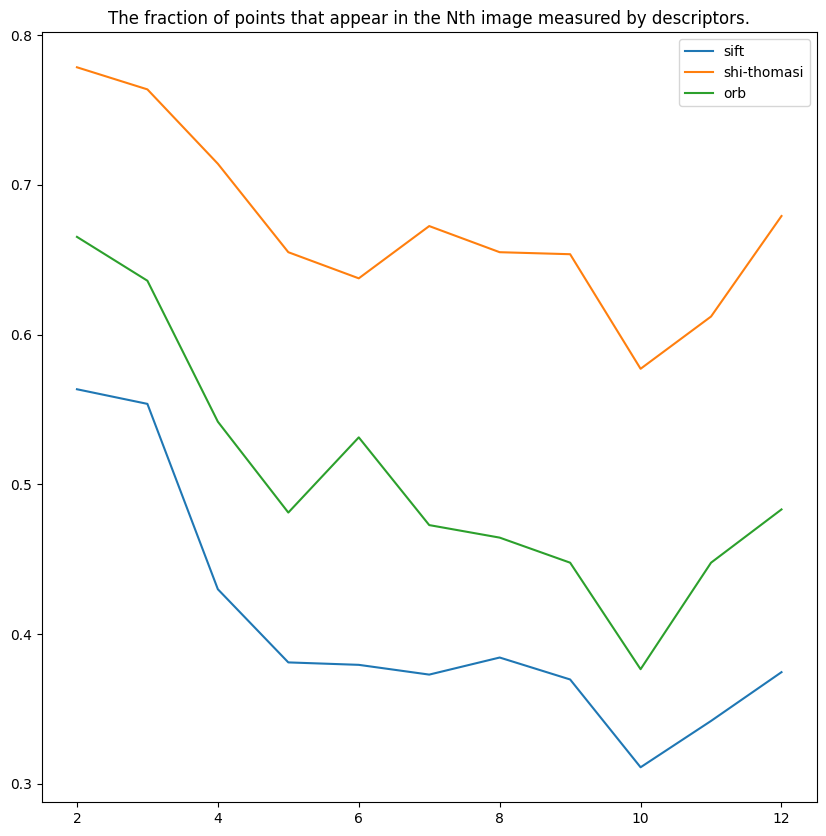

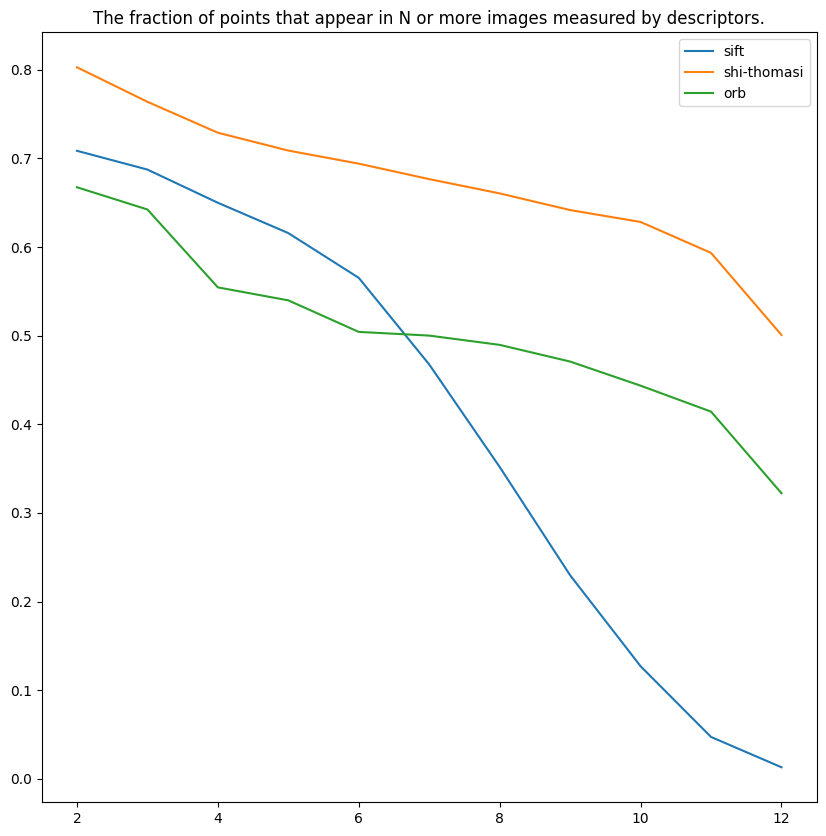

In [144]:
print("Descriptor-based estimation of repeatability")
results = get_results(calculate_descriptor_repeatability)

for method in methods:
  print(method, "{:.2f}".format(results[method]["repeatability"]))
plot_distribution(results, "The fraction of points that appear in the Nth image measured by descriptors.", "y_2",
                  "nth_descriptor", '/content/graphs_dir')
plot_distribution(results, "The fraction of points that appear in N or more images measured by descriptors.", "y_1",
                  "n_descriptor", '/content/graphs_dir')
print()

In [148]:
print("working time")
for key in results:
    print(key, "{:.5f}".format(results[key]["time"]/1000), "ms")

working time
sift 0.04538 ms
shi-thomasi 0.00487 ms
orb 0.00573 ms


motion estimation based estimation of repeatability


100%|██████████| 11/11 [00:00<00:00, 93.29it/s]


sift 0.47
shi-thomasi 0.50
orb 0.49


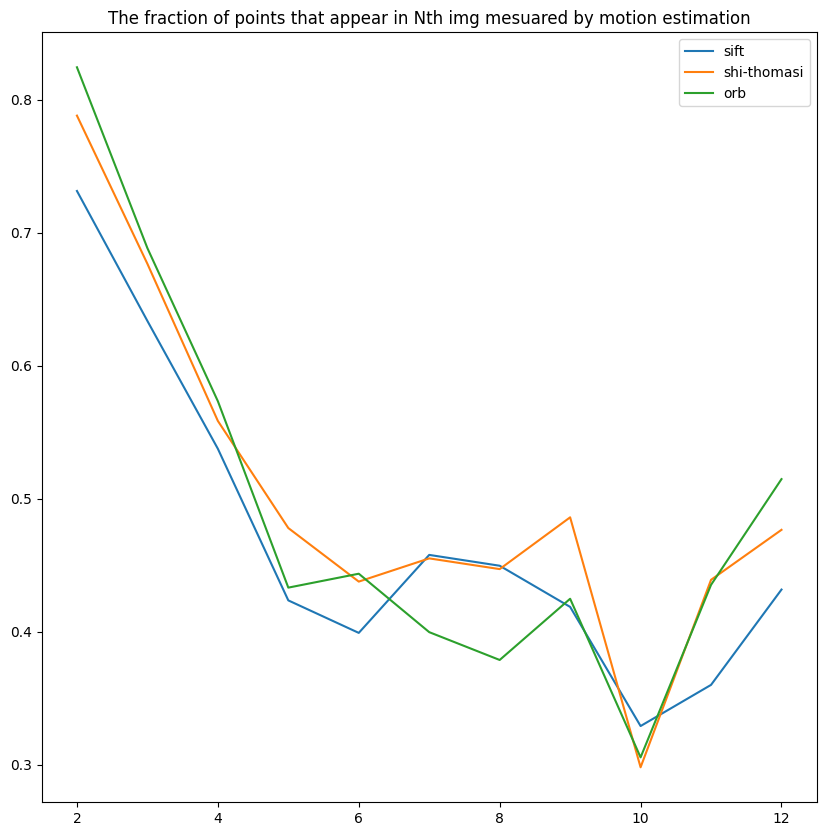

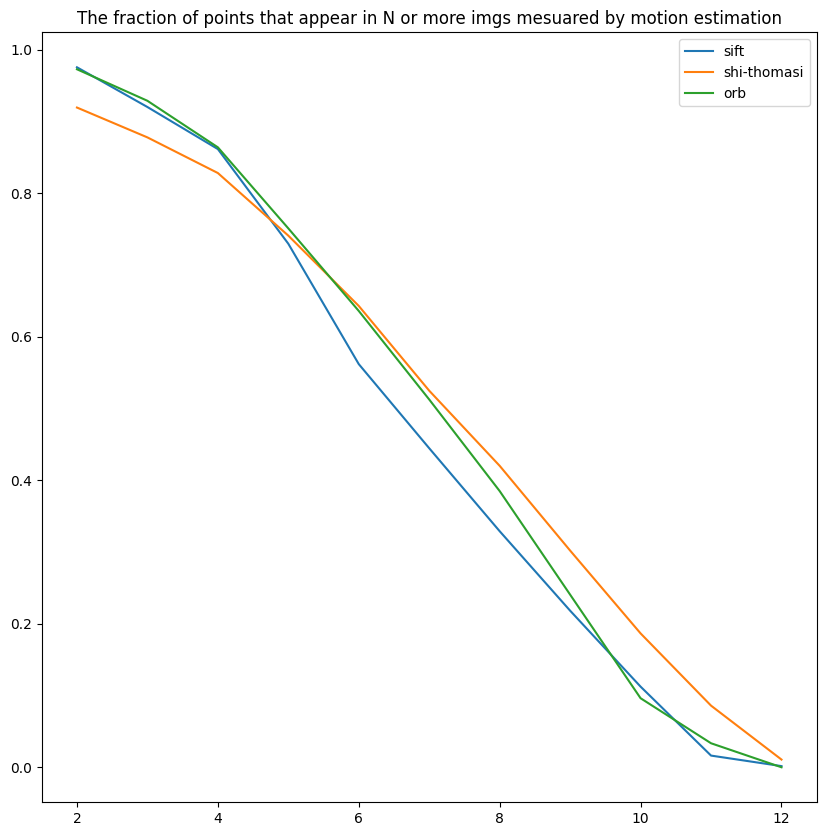

In [146]:
print("motion estimation based estimation of repeatability")
results = get_results(calculate_repeatability_motion)
for method in methods:
  print(method, "{:.2f}".format(results[method]["repeatability"]))

plot_distribution(results, "The fraction of points that appear in Nth img mesuared by motion estimation",
              "y_2", "nth_motion", '/content/graphs_dir')
plot_distribution(results, "The fraction of points that appear in N or more imgs mesuared by motion estimation",
              "y_1", "n_motion", '/content/graphs_dir')

In [147]:
print("working time")
for key in results:
    print(key, "{:.5f}".format(results[key]["time"]/1000), "ms")

working time
sift 0.04538 ms
shi-thomasi 0.00487 ms
orb 0.00573 ms
